In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

import os
from tqdm import tqdm
from sklearn import preprocessing
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


## Initiating Hyper Params

In [5]:
learning_rate = 0.001
im_size = 128
training_dir = '../inputs/train/'

## Inspecting train data set

In [35]:
df_train = pd.read_csv('../inputs/train.csv')
df_train.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [42]:
def process_image(file_dir, name):
    x = mpimg.imread(file_dir + name)
    return cv2.resize(x, (im_size, im_size))

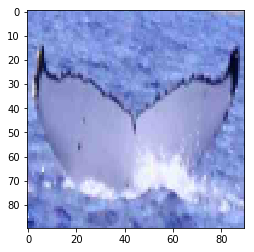

In [43]:
img = process_image(training_dir, df_train.Image[3])
plt.imshow(img)
plt.show()

# Data preparation

In [45]:
# Do we need to one-hot encode labels?
X_train = []
y_train = []
X_test = []

In [ ]:
for file, label in tqdm(df_train.values):
    img = process_image(training_dir, file)
    X_train.append(img)
    y_train.append(label)


  6%|▋         | 635/9850 [00:04<01:09, 132.18it/s]

  7%|▋         | 651/9850 [00:04<01:09, 132.73it/s]Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/jasons/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/jasons/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/jasons/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


 20%|██        | 1971/9850 [00:15<01:00, 130.83it/s]


 45%|████▍     | 4414/9850 [00:30<00:38, 142.52it/s]


 67%|██████▋   | 6635/9850 [00:47<00:22, 140.67it/s]


 79%|███████▉  | 7825/9850 [00:55<00:14, 142.15it/s]

## Model construction

In [81]:
# Create the base pre-trained model
# Can't download weights in the kernel
base_model = VGG19(
    weights='imagenet',
    #weights = 'None',
    include_top=False, input_shape=(im_size, im_size, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
print('checking num class ', num_class)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]


base_model.summary()

checking num class  6895
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 90, 90, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 90, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 90, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 22, 128)   

## Model train

In [82]:
model.fit(train_X, train_y, epochs=1, validation_data=(valid_X, valid_y), verbose=1)

ValueError: Error when checking input: expected input_9 to have 4 dimensions, but got array with shape (6895, 1)